# Exploration_CR7
---
10. 트랜스포머로 만드는 대화형 챗봇 [프로젝트]


10-1. 프로젝트: 한국어 데이터로 챗봇 만들기


### Step 1. 데이터 수집하기

한국어 챗봇 데이터는 송영숙님이 공개한 챗봇 데이터를 사용합니다.

이 데이터는 아래의 링크에서 다운로드할 수 있습니다.

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

### Step 2. 데이터 전처리하기

영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행해야 할 수도 있습니다.

### Step 3. SubwordTextEncoder 사용하기

한국어 데이터는 형태소 분석기를 사용하여 토크나이징을 해야 한다고 많은 분이 알고 있습니다. 하지만 여기서는 형태소 분석기가 아닌 위 실습에서 사용했던 내부 단어 토크나이저인 SubwordTextEncoder를 그대로 사용해보세요.

### Step 4. 모델 구성하기

위 실습 내용을 참고하여 트랜스포머 모델을 구현합니다.

### Step 5. 모델 평가하기

Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import os
import re
import numpy as np
import matplotlib.pyplot as plt
print("힣")

힣


### Step 1. 데이터 수집

---

lms에 올라와있는 데이터 사용

[songys/Chatbot_data](https://github.com/songys/Chatbot_data/blob/master/ChatbotData.csv)

In [2]:
import pandas as pd

# CSV 파일 경로
file_path = '/aiffel/data/ChatbotData .csv'

# CSV 파일 읽기
df = pd.read_csv(file_path)

# 데이터 확인
print(df.head())

                 Q            A  label
0           12시 땡!   하루가 또 가네요.      0
1      1지망 학교 떨어졌어    위로해 드립니다.      0
2     3박4일 놀러가고 싶다  여행은 언제나 좋죠.      0
3  3박4일 정도 놀러가고 싶다  여행은 언제나 좋죠.      0
4          PPL 심하네   눈살이 찌푸려지죠.      0


In [3]:
# 사용할 샘플의 최대 개수(데이터셋 자체가 11876개 이고, 전에 돌렸던 모델에 비해 크기가 작기 때문에 그대로 진행하겠다.)
MAX_SAMPLES = 11876
print(MAX_SAMPLES)

11876


### Step 2. 데이터 전처리하기

---
영어 데이터와는 전혀 다른 데이터인 만큼 영어 데이터에 사용했던 전처리와 일부 동일한 전처리도 필요하겠지만 전체적으로는 다른 전처리를 수행


- 한글과 기본 구두점을 제외한 모든 문자 제거: 한글 텍스트 처리 시, 영어와 달리 알파벳과 숫자를 제외하고 한글과 기본 구두점만을 유지하는 것
- 공백 정리: 연속된 공백은 하나의 공백으로 줄이기
- 문장부호 간격 조정: 한글에서도 문장부호와 단어 사이의 간격을 조정

In [4]:
import re

def preprocess_sentence(sentence):
    # 입력받은 문장을 소문자로 변경하고 양쪽 공백을 제거
    sentence = sentence.lower().strip()

    # 한글, 문장부호를 제외한 모든 문자를 공백으로 대체
    sentence = re.sub(r"[^가-힣?.!,ㅠㅎㅋ]+", " ", sentence)

    # 문장부호 앞뒤에 공백 추가
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)

    # 연속된 공백은 하나의 공백으로
    sentence = re.sub(r'[" "]+', " ", sentence)

    sentence = sentence.strip()
    return sentence

# 테스트
print(preprocess_sentence("안녕하세요? 저는 챗봇입니다!!"))

안녕하세요 ? 저는 챗봇입니다 ! !


In [5]:
import pandas as pd

def load_conversations():
    # 데이터셋 로드
    df = pd.read_csv(file_path)
    
    # 질문과 답변 쌍
    questions, answers = [], []
    for i in range(len(df)):
        # 전처리 함수를 적용
        questions.append(preprocess_sentence(df['Q'][i]))
        answers.append(preprocess_sentence(df['A'][i]))

        if len(questions) >= MAX_SAMPLES:
            break
    return questions, answers

# 데이터를 로드하고 전처리하여 질문을 questions, 답변을 answers에 저장합니다.

questions, answers = load_conversations()

print('전체 샘플 수 :', len(questions))

print('전체 샘플 수 :', len(answers))

전체 샘플 수 : 11823
전체 샘플 수 : 11823


In [6]:
# 5번째 샘플 출력으로 확인
print(questions[5])
print(answers[5])

카드 망가졌어
다시 새로 사는 게 마음 편해요 .


### Step 3. SubwordTextEncoder 사용하기 (병렬 데이터 전처리)

1. SubwordTextEncoder 사용: 이 토크나이저는 서브워드 단위로 토큰화하고 각 토큰을 고유한 정수로 인코딩합니다. 한글의 경우, 음절(글자) 단위가 서브워드에 해당할 수 있으며, 이는 한글의 자모(자음과 모음) 구조상 효과적일 수 있습니다.

2. START_TOKEN 및 END_TOKEN 추가: 각 문장의 시작과 끝에 특별 토큰을 추가하는 것은 한글에도 동일하게 적용됩니다. 이는 모델이 문장의 시작과 끝을 인식하는 데 도움을 줍니다.

3. 최대 길이에 따른 필터링: 최대 길이 MAX_LENGTH를 넘는 문장을 필터링하는 것은 메모리 효율성과 모델 성능을 고려하여 중요합니다. 한글의 경우, 영어와 달리 한 글자가 한 음절을 나타내므로, 동일한 MAX_LENGTH를 설정할 때 영어보다 더 많은 정보를 포함할 수 있습니다.

4. 패딩 추가: MAX_LENGTH보다 짧은 문장에 패딩을 추가하는 것은 모든 문장을 동일한 길이로 맞추기 위해 필요합니다. 이는 한글에도 동일하게 적용됩니다.

### 1. 단어장(Vocabulary) 만들기

---

우선 각 단어에 고유한 정수 인덱스를 부여하기 위해서 단어장(Vocabulary)을 만들어보겠습니다. 단어장을 만들 때는 질문과 답변 데이터셋을 모두 사용하여 만듭니다.

In [7]:
import tensorflow_datasets as tfds

print("오래 걸릴 수 있다!")

# 질문과 답변 데이터셋에 대해서 Vocabulary 생성
tokenizer = tfds.deprecated.text.SubwordTextEncoder.build_from_corpus(
    questions + answers, target_vocab_size=2**13)

print("힣")

오래 걸릴 수 있다!
힣


디코더의 문장 생성 과정에서 사용할 '시작 토큰'과 '종료 토큰'에 대해서도 임의로 단어장에 추가하여서 정수를 부여해준다.

이미 생성된 단어장의 번호와 겹치지 않도록 각각 단어장의 크기와 그보다 1이 큰 수를 번호로 부여한다!

In [8]:
# 시작 토큰과 종료 토큰에 고유한 정수를 부여합니다.
START_TOKEN, END_TOKEN = [tokenizer.vocab_size], [tokenizer.vocab_size + 1]
print("힣")

힣


시작 토큰과 종료 토큰에 부여된 정수를 출력

In [9]:
print('START_TOKEN의 번호 :' ,[tokenizer.vocab_size])
print('END_TOKEN의 번호 :' ,[tokenizer.vocab_size + 1])

START_TOKEN의 번호 : [8134]
END_TOKEN의 번호 : [8135]


각각 8,134과 8,135라는 점에서 현재 단어장의 크기가 8,134(0번부터 8,133번)이라는 의미히다.

두 개의 토큰을 추가해 주었기 때문에 단어장의 크기도 +2임을 명시해 주어야한다.

In [10]:
# 시작 토큰과 종료 토큰을 고려하여 +2를 하여 단어장의 크기를 산정
VOCAB_SIZE = tokenizer.vocab_size + 2
print(VOCAB_SIZE)

8136


### 2. 각 단어를 고유한 정수로 인코딩(Integer encoding) & 패딩(Padding)

---
위에서 tensorflow_datasets의 SubwordTextEncoder를 사용해서 tokenizer를 정의하고 Vocabulary를 만들었다면, tokenizer.encode()로 각 단어를 정수로 변환할 수 있고 또는 tokenizer.decode()를 통해 정수 시퀀스를 단어 시퀀스로 변환할 수 있습니다.

예를 들어서 22번째 샘플을 tokenizer.encode()의 입력으로 사용해서 변환 결과를 봅시다.

In [11]:
# 임의의 22번째 샘플에 대해서 정수 인코딩 작업을 수행.
# 각 토큰을 고유한 정수로 변환
print('정수 인코딩 후의 21번째 질문 샘플: {}'.format(tokenizer.encode(questions[21])))
print('정수 인코딩 후의 21번째 답변 샘플: {}'.format(tokenizer.encode(answers[21])))

정수 인코딩 후의 21번째 질문 샘플: [5746, 612, 2485, 4152]
정수 인코딩 후의 21번째 답변 샘플: [2353, 7488, 7, 6251, 97, 1]


각 단어에 고유한 정수가 부여된 Vocabulary를 기준으로 단어 시퀀스가 정수 시퀀스로 인코딩된 결과를 확인할 수 있습니다. 위의 결과와 마찬가지로 질문과 답변 셋에 대해서 전부 정수 인코딩 을 수행합니다. 이와 동시에 문장의 최대 길이를 정하고, 해당 길이로 패딩(padding) 합니다.

한글 텍스트 데이터를 처리할 때 적절한 최대 허용 길이(MAX_LENGTH)를 설정하는 것은 중요합니다. 영어와 비교했을 때, 한글은 각 글자가 하나의 음절을 나타내므로, 동일한 MAX_LENGTH를 설정하더라도 실제로 표현할 수 있는 정보의 양이 다를 수 있습니다.

한글의 경우 다음과 같은 점들을 고려하여 MAX_LENGTH를 설정할 수 있습니다:

1. 평균 문장 길이: 데이터셋에 있는 문장들의 평균 길이를 고려하여 설정합니다. 너무 긴 문장은 잘리게 되므로, 대부분의 문장이 잘리지 않도록 평균 길이보다 약간 큰 값을 설정하는 것이 좋습니다.

2. 자원 제약: 모델의 학습 시간과 메모리 사용량은 MAX_LENGTH에 영향을 받습니다. 너무 긴 MAX_LENGTH는 이러한 자원 사용량을 증가시킬 수 있습니다.

3. 문맥 이해: 너무 짧은 MAX_LENGTH는 문장의 문맥을 제대로 파악하기 어렵게 만들 수 있습니다. 모델이 충분한 문맥을 이해할 수 있도록 적절한 길이를 설정합니다.

한글 텍스트의 경우, MAX_LENGTH를 영어보다 조금 더 길게 설정하는 것이 일반적입니다. 예를 들어, 영어 데이터셋에서 MAX_LENGTH가 40이라면, 한글 데이터셋에서는 50~60 정도로 설정하는 것을 고려해볼 수 있습니다. 

In [12]:
# 샘플의 최대 허용 길이 또는 패딩 후의 최종 길이 -> 나는 한글 데이터셋의 일반적인 설정을 고려해 55로 주겠다.
MAX_LENGTH = 55
print(MAX_LENGTH)

55


In [13]:
# 정수 인코딩, 최대 길이를 초과하는 샘플 제거, 패딩
def tokenize_and_filter(inputs, outputs):
  tokenized_inputs, tokenized_outputs = [], []
  
  for (sentence1, sentence2) in zip(inputs, outputs):
    # 정수 인코딩 과정에서 시작 토큰과 종료 토큰을 추가
    sentence1 = START_TOKEN + tokenizer.encode(sentence1) + END_TOKEN
    sentence2 = START_TOKEN + tokenizer.encode(sentence2) + END_TOKEN

    # 최대 길이 55이하인 경우에만 데이터셋으로 허용
    if len(sentence1) <= MAX_LENGTH and len(sentence2) <= MAX_LENGTH:
      tokenized_inputs.append(sentence1)
      tokenized_outputs.append(sentence2)
  
  # 최대 길이 55으로 모든 데이터셋을 패딩
  tokenized_inputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_inputs, maxlen=MAX_LENGTH, padding='post')
  tokenized_outputs = tf.keras.preprocessing.sequence.pad_sequences(
      tokenized_outputs, maxlen=MAX_LENGTH, padding='post')
  
  return tokenized_inputs, tokenized_outputs
print("힣")

힣


정수 인코딩 과정을 수행하면서 샘플의 길이가 55을 넘는 경우는 샘플들을 필터링하였으므로 일부 샘플이 제외되었습니다. 단어장의 크기와 샘플의 개수를 확인

In [14]:
questions, answers = tokenize_and_filter(questions, answers)
print('단어장의 크기 :',(VOCAB_SIZE))
print('필터링 후의 질문 샘플 개수: {}'.format(len(questions)))
print('필터링 후의 답변 샘플 개수: {}'.format(len(answers)))

단어장의 크기 : 8136
필터링 후의 질문 샘플 개수: 11823
필터링 후의 답변 샘플 개수: 11823


### 3. 포지셔널 인코딩(Positional Encoding)

트랜스포머(Transformer) 모델과 같은 일부 신경망 모델에서 입력 데이터의 순서나 위치 정보를 모델에 제공하는 방법


**포지셔널 인코딩의 필요성**

전통적인 순차적 모델들(예: RNN, LSTM)은 입력 데이터를 시퀀스 순서대로 처리.
이러한 모델들은 입력 데이터의 순서를 자연스럽게 고려하지만, 트랜스포머 모델은 이러한 순서 정보가 내재되어 있지 않다. 
트랜스포머 모델은 입력 데이터의 모든 요소를 동시에 처리(병렬 처리)하기 때문에, 별도의 방법으로 순서 정보를 제공해야 한다. 


**포지셔널 인코딩의 작동 방식**

포지셔널 인코딩은 각 단어의 위치에 대한 정보를 벡터 형태로 변환하는 방식으로 이루어진다. 이러한 벡터는 각 단어의 임베딩 벡터에 더해져, 모델이 단어의 위치 정보를 인식할 수 있도록 해준다.


**구현 방법**

- 정적 포지셔널 인코딩: 트랜스포머의 원래 논문에서는 사인 함수와 코사인 함수를 사용하여 포지셔널 인코딩을 생성. 이 방법은 모델에 고정된 위치 정보를 제공.
- 동적 포지셔널 인코딩: 다른 방법으로는 학습 가능한 포지셔널 인코딩을 사용. 모델이 학습 과정에서 위치 정보를 스스로 학습.

In [15]:
# 포지셔널 인코딩 레이어 클래스 정의
class PositionalEncoding(tf.keras.layers.Layer):

  def __init__(self, position, d_model):
    super(PositionalEncoding, self).__init__()
    # 포지셔널 인코딩 행렬을 미리 계산
    self.pos_encoding = self.positional_encoding(position, d_model)

  def get_angles(self, position, i, d_model):
    # 포지션과 차원 인덱스를 기반으로 각도를 계산하는 함수
    angles = 1 / tf.pow(10000, (2 * (i // 2)) / tf.cast(d_model, tf.float32))
    return position * angles

  def positional_encoding(self, position, d_model):
    # 주어진 문장 길이와 임베딩 차원에 맞는 포지셔널 인코딩 행렬을 생성하는 함수 / 각도 배열 생성
    angle_rads = self.get_angles(
        position=tf.range(position, dtype=tf.float32)[:, tf.newaxis],
        i=tf.range(d_model, dtype=tf.float32)[tf.newaxis, :],
        d_model=d_model)

    # 배열의 짝수 인덱스에는 sin 함수 적용
    sines = tf.math.sin(angle_rads[:, 0::2])
    # 배열의 홀수 인덱스에는 cosine 함수 적용
    cosines = tf.math.cos(angle_rads[:, 1::2])

    # sin과 cosine이 교차되도록 배열을 재구성합니다.
    pos_encoding = tf.stack([sines, cosines], axis=0)
    pos_encoding = tf.transpose(pos_encoding,[1, 2, 0]) 
    pos_encoding = tf.reshape(pos_encoding, [position, d_model])

    # 배치 차원을 추가
    pos_encoding = pos_encoding[tf.newaxis, ...]
    return tf.cast(pos_encoding, tf.float32)

  def call(self, inputs):
    # 입력에 포지셔널 인코딩
    return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]

print("힣")

힣


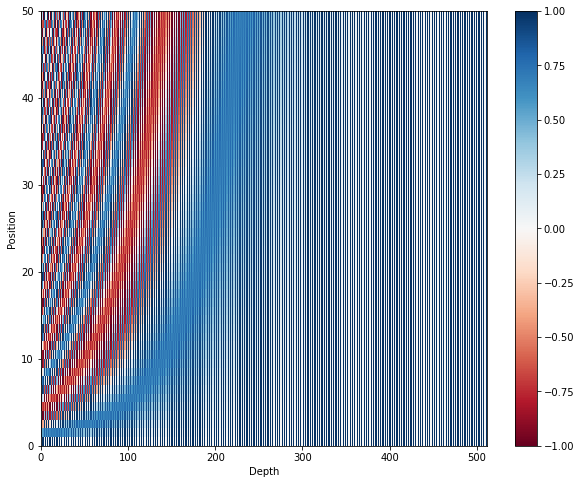

In [16]:
sample_pos_encoding = PositionalEncoding(50, 512)

plt.figure(figsize=(10, 8))
plt.pcolormesh(sample_pos_encoding.pos_encoding.numpy()[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

In [17]:
# 스케일드 닷 프로덕트 어텐션 함수
def scaled_dot_product_attention(query, key, value, mask):
  # 어텐션 가중치는 Q와 K의 닷 프로덕트
  matmul_qk = tf.matmul(query, key, transpose_b=True)

  # 가중치를 정규화
  depth = tf.cast(tf.shape(key)[-1], tf.float32)
  logits = matmul_qk / tf.math.sqrt(depth)

  # 패딩에 마스크 추가
  if mask is not None:
    logits += (mask * -1e9)

  # softmax적용
  attention_weights = tf.nn.softmax(logits, axis=-1)

  # 최종 어텐션은 가중치와 V의 닷 프로덕트
  output = tf.matmul(attention_weights, value)
  return output

print("힣")

힣


In [18]:
class MultiHeadAttention(tf.keras.layers.Layer):

  def __init__(self, d_model, num_heads, name="multi_head_attention"):
    super(MultiHeadAttention, self).__init__(name=name)
    self.num_heads = num_heads
    self.d_model = d_model

    assert d_model % self.num_heads == 0

    self.depth = d_model // self.num_heads

    self.query_dense = tf.keras.layers.Dense(units=d_model)
    self.key_dense = tf.keras.layers.Dense(units=d_model)
    self.value_dense = tf.keras.layers.Dense(units=d_model)

    self.dense = tf.keras.layers.Dense(units=d_model)

  def split_heads(self, inputs, batch_size):
    inputs = tf.reshape(
        inputs, shape=(batch_size, -1, self.num_heads, self.depth))
    return tf.transpose(inputs, perm=[0, 2, 1, 3])

  def call(self, inputs):
    query, key, value, mask = inputs['query'], inputs['key'], inputs[
        'value'], inputs['mask']
    batch_size = tf.shape(query)[0]

    # Q, K, V에 각각 Dense를 적용합니다
    query = self.query_dense(query)
    key = self.key_dense(key)
    value = self.value_dense(value)

    # 병렬 연산을 위한 머리를 여러 개 만듭니다
    query = self.split_heads(query, batch_size)
    key = self.split_heads(key, batch_size)
    value = self.split_heads(value, batch_size)

    # 스케일드 닷 프로덕트 어텐션 함수 (이 부분은 외부에서 정의되어야 함)
    scaled_attention = scaled_dot_product_attention(query, key, value, mask)
    scaled_attention = tf.transpose(scaled_attention, perm=[0, 2, 1, 3])

    # 어텐션 연산 후에 각 결과를 다시 연결합니다
    concat_attention = tf.reshape(scaled_attention,
                                  (batch_size, -1, self.d_model))

    # 최종 결과에도 Dense를 한 번 더 적용합니다
    outputs = self.dense(concat_attention)

    return outputs

print("힣")

힣


### 패딩 마스킹

In [19]:
def create_padding_mask(x):
  mask = tf.cast(tf.math.equal(x, 0), tf.float32)
  # (batch_size, 1, 1, sequence length)
  return mask[:, tf.newaxis, tf.newaxis, :]
print("힣")

힣


트랜스포머
하지만 트랜스포머의 경우, 전체 문장이 문장 행렬로 들어가기 때문에 위치와 상관없이 모든 단어를 참고해서 다음 단어를 예측할 수 있습니다. 하지만 사실 우리가 원하는 것은 이전 단어들로부터 다음 단어를 예측하는 훈련을 제대로 하는 것입니다. 따라서 이러한 문제를 해결하기 위해 자신보다 다음에 나올 단어를 참고하지 않도록 가리는 기법이 룩 어헤드 마스킹 기법입니다.

이 기법은 어텐션을 수행할 때, Query 단어 뒤에 나오는 Key 단어들에 대해서는 마스킹 합니다.

![](https://d3s0tskafalll9.cloudfront.net/media/images/_.max-800x600.png)
위의 그림에서 빨간색으로 색칠된 부분은 마스킹을 표현하고 있습니다. 빨간색은 실제 어텐션 연산에서 가리는 역할을 하여 어텐션 연산 시에 현재 단어를 기준으로 이전 단어들하고만 유사도를 구할 수 있습니다. 행을 Query, 열을 Key로 표현된 행렬임을 감안하고 천천히 행렬을 살펴봅시다.

예를 들어 Query 단어가 '찾고'라고 한다면, 이 '찾고'라는 행에는 
(s), (나는), (행복을), (찾고)
    
까지의 열만 보이고 그 뒤 열은 아예 빨간색으로 칠해져 있습니다. 
    
즉, 유사도를 구할 수 없도록 해놓았습니다. 저 빨간색 부분을 마스킹 함수로 구현하면 다음과 같습니다.

트랜스포머 모델에서 디코더의 각 레이어가 이전의 모든 출력을 참조할 수 있도록 하면서도, 아직 예측하지 않은 미래의 단어들을 참조하지 못하게 합니다. 또한, 패딩된 위치도 마스킹하여 모델이 불필요한 위치에 주의를 기울이지 않도록 합니다. 이러한 마스킹 기법은 트랜스포머 모델이 효과적으로 시퀀스를 처리하고 예측하는 데 중요한 역할을 합니다.

In [20]:
def create_look_ahead_mask(x):
  seq_len = tf.shape(x)[1]
  look_ahead_mask = 1 - tf.linalg.band_part(tf.ones((seq_len, seq_len)), -1, 0)
  padding_mask = create_padding_mask(x)
  return tf.maximum(look_ahead_mask, padding_mask)
print("힣")

힣


### 인코더 층을 쌓아 인코더 만들기

---

이렇게 구현한 인코더 층을 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 인코더 층을 쌓음으로써 트랜스포머의 인코더가 완성됩니다.

인코더와 디코더 내부에서는 각 서브 층 이후에 훈련을 돕는 **Layer Normalization**이라는 테크닉이 사용되었습니다. 위 그림에서는 **Normalize**라고 표시된 부분에 해당됩니다.

트랜스포머는 하이퍼파라미터인 **num_layers** 개수의 인코더 층을 쌓습니다. 논문에서는 총 6개의 인코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [21]:
# 인코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 두 개의 서브 레이어가 존재합니다.
def encoder_layer(units, d_model, num_heads, dropout, name="encoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention = MultiHeadAttention(
      d_model, num_heads, name="attention")({
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': padding_mask
      })

  # 어텐션의 결과는 Dropout과 Layer Normalization이라는 훈련을 돕는 테크닉을 수행
  attention = tf.keras.layers.Dropout(rate=dropout)(attention)
  attention = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(inputs + attention)

  # 두 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention + outputs)

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("힣")

힣


In [22]:
def encoder(vocab_size,
            num_layers,
            units,
            d_model,
            num_heads,
            dropout,
            name="encoder"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")

  # 패딩 마스크 사용
  padding_mask = tf.keras.Input(shape=(1, 1, None), name="padding_mask")

  # 임베딩 레이어
  embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
  embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

  # 포지셔널 인코딩
  embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

  outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

  # num_layers만큼 쌓아올린 인코더의 층.
  for i in range(num_layers):
    outputs = encoder_layer(
        units=units,
        d_model=d_model,
        num_heads=num_heads,
        dropout=dropout,
        name="encoder_layer_{}".format(i),
    )([outputs, padding_mask])

  return tf.keras.Model(
      inputs=[inputs, padding_mask], outputs=outputs, name=name)
print("힣")

힣


### 디코더 층

---

디코더는 인코더와 비슷하지만, 인코더보다 조금 더 복잡합니다. 인코더는 두 개의 서브 층으로 구성되지만, 디코더는 세 개의 서브 층으로 구성된다는 점이 다릅니다.

첫 번째는 **셀프 어텐션**, 두 번째는 **인코더-디코더 어텐션**, 세 번째는 **피드 포워드 신경망**입니다. **인코더-디코더 어텐션**은 셀프 어텐션과는 달리, Query가 디코더의 벡터인 반면에 Key와 Value가 인코더의 벡터라는 특징이 있습니다. 이 부분이 인코더가 입력 문장으로부터 정보를 디코더에 전달하는 과정입니다.

인코더의 **셀프 어텐션**과 마찬가지로 디코더의 **셀프 어텐션**, **인코더-디코더 어텐션** 두 개의 어텐션 모두 **스케일드 닷 프로덕트 어텐션**을 **멀티 헤드 어텐션**으로 병렬적으로 수행합니다.

In [23]:
# 디코더 하나의 레이어를 함수로 구현.
# 이 하나의 레이어 안에는 세 개의 서브 레이어가 존재합니다.
def decoder_layer(units, d_model, num_heads, dropout, name="decoder_layer"):
  inputs = tf.keras.Input(shape=(None, d_model), name="inputs")
  enc_outputs = tf.keras.Input(shape=(None, d_model), name="encoder_outputs")
  look_ahead_mask = tf.keras.Input(
      shape=(1, None, None), name="look_ahead_mask")
  padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

  # 첫 번째 서브 레이어 : 멀티 헤드 어텐션 수행 (셀프 어텐션)
  attention1 = MultiHeadAttention(
      d_model, num_heads, name="attention_1")(inputs={
          'query': inputs,
          'key': inputs,
          'value': inputs,
          'mask': look_ahead_mask
      })

  # 멀티 헤드 어텐션의 결과는 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention1 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention1 + inputs)

  # 두 번째 서브 레이어 : 마스크드 멀티 헤드 어텐션 수행 (인코더-디코더 어텐션)
  attention2 = MultiHeadAttention(
      d_model, num_heads, name="attention_2")(inputs={
          'query': attention1,
          'key': enc_outputs,
          'value': enc_outputs,
          'mask': padding_mask
      })

  # 마스크드 멀티 헤드 어텐션의 결과는
  # Dropout과 LayerNormalization이라는 훈련을 돕는 테크닉을 수행
  attention2 = tf.keras.layers.Dropout(rate=dropout)(attention2)
  attention2 = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(attention2 + attention1)

  # 세 번째 서브 레이어 : 2개의 완전연결층
  outputs = tf.keras.layers.Dense(units=units, activation='relu')(attention2)
  outputs = tf.keras.layers.Dense(units=d_model)(outputs)

  # 완전연결층의 결과는 Dropout과 LayerNormalization 수행
  outputs = tf.keras.layers.Dropout(rate=dropout)(outputs)
  outputs = tf.keras.layers.LayerNormalization(
      epsilon=1e-6)(outputs + attention2)

  return tf.keras.Model(
      inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
      outputs=outputs,
      name=name)
print("힣")

힣


### 디코더 층을 쌓아 디코더 만들기

---

이렇게 구현한 디코더의 층은 **임베딩 층(Embedding layer)** 과 **포지셔널 인코딩(Positional Encoding)** 을 연결하고, 사용자가 원하는 만큼 디코더 층을 쌓아 트랜스포머의 디코더가 완성됩니다.

인코더와 마찬가지로 **num_layers** 개수의 디코더 층을 쌓습니다. 논문에서는 총 6개의 디코더 층을 사용하였지만, 실습에서는 학습 시간을 고려하여 그보다 적은 개수를 사용할 예정입니다.

In [24]:
def decoder(vocab_size, num_layers, units, d_model, num_heads, dropout, name='decoder'):
    # 디코더의 입력을 정의합니다.
    inputs = tf.keras.Input(shape=(None,), name='inputs')

    # 인코더의 출력을 정의합니다.
    enc_outputs = tf.keras.Input(shape=(None, d_model), name='encoder_outputs')

    # look-ahead mask를 정의합니다. 이것은 디코더가 아직 예측하지 않은 미래의 단어들을 참조하지 못하게 합니다.
    look_ahead_mask = tf.keras.Input(shape=(1, None, None), name='look_ahead_mask')

    # 패딩 마스크를 정의합니다. 이것은 패딩된 부분을 마스킹합니다.
    padding_mask = tf.keras.Input(shape=(1, 1, None), name='padding_mask')

    # 임베딩 레이어: 단어를 d_model 차원의 벡터로 변환합니다.
    embeddings = tf.keras.layers.Embedding(vocab_size, d_model)(inputs)
    embeddings *= tf.math.sqrt(tf.cast(d_model, tf.float32))

    # 포지셔널 인코딩 레이어: 각 단어의 위치 정보를 제공합니다.
    embeddings = PositionalEncoding(vocab_size, d_model)(embeddings)

    # Dropout: 모델이 오버피팅되는 것을 방지하기 위해 사용됩니다.
    outputs = tf.keras.layers.Dropout(rate=dropout)(embeddings)

    # 디코더 레이어를 num_layers만큼 쌓습니다.
    for i in range(num_layers):
        outputs = decoder_layer(
            units=units,
            d_model=d_model,
            num_heads=num_heads,
            dropout=dropout,
            name='decoder_layer_{}'.format(i),
        )(inputs=[outputs, enc_outputs, look_ahead_mask, padding_mask])

    # 디코더 모델을 정의합니다.
    return tf.keras.Model(
        inputs=[inputs, enc_outputs, look_ahead_mask, padding_mask],
        outputs=outputs,
        name=name)

print("힣")

힣


### 교사 강요(Teacher Forcing) 사용하기

---

**tf.data.Dataset API** 는 훈련 프로세스의 속도가 빨라지도록 입력 파이프라인을 구축하는 API입니다.

이를 적극 사용하기 위해서 질문과 답변의 쌍을 `tf.data.Dataset`의 입력으로 넣어주는 작업을 합니다.

이때, 디코더의 입력과 실제값(레이블)을 정의해 주기 위해서는 **교사 강요(Teacher Forcing)** 이라는 언어 모델의 훈련 기법을 이해해야만 합니다.

"교사 강요(Teacher Forcing)"는 순차적 데이터를 처리하는 신경망 모델, 특히 자연어 처리 분야에서 흔히 사용되는 훈련 기법입니다. 이 기법은 주로 순환 신경망(Recurrent Neural Network, RNN)이나 트랜스포머(Transformer)와 같은 모델들에서 적용됩니다.

교사 강요의 개념:
교사 강요는 모델 훈련 시에 실제 이전 시점의 출력 대신 실제 이전 시점의 정답(타겟) 데이터를 다음 시점의 입력으로 제공하는 방법입니다.

예를 들어, "A B C"라는 시퀀스를 예측하는 모델을 훈련할 때, 일반적인 방식은 첫 번째 단계에서 "A"를 입력으로 받아 모델의 예측 "B'"를 생성하고, 다음 단계에서는 이 "B'"를 입력으로 사용하여 "C'"를 예측하는 식입니다. 하지만 교사 강요를 사용할 경우, 두 번째 단계에서 모델의 예측 "B'" 대신 실제 데이터 "B"를 입력으로 사용하여 "C'"를 예측합니다.

교사 강요의 장점:
빠른 수렴: 모델이 올바른 출력을 더 빨리 학습하게 도와줍니다.
안정적인 훈련: 특히 초기 단계에서 모델이 잘못된 예측을 하는 경우, 교사 강요는 모델이 정답을 통해 올바른 방향으로 학습하는 데 도움을 줍니다.

In [25]:
BATCH_SIZE = 64
BUFFER_SIZE = 20000

# 디코더는 이전의 target을 다음의 input으로 사용합니다.
# 이에 따라 outputs에서는 START_TOKEN을 제거하겠습니다.
dataset = tf.data.Dataset.from_tensor_slices((
    {
        'inputs': questions,
        'dec_inputs': answers[:, :-1]
    },
    {
        'outputs': answers[:, 1:]
    },
))

dataset = dataset.cache()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE)
dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
print("힣")

힣


### Step 4. 모델 구성하기

---
이제 앞서 사용한 인코더 층 함수와 디코더 층 함수를 사용하여 트랜스포머 함수를 정의합니다.

In [26]:
def transformer(vocab_size,
                num_layers,
                units,
                d_model,
                num_heads,
                dropout,
                name="transformer"):
  inputs = tf.keras.Input(shape=(None,), name="inputs")
  dec_inputs = tf.keras.Input(shape=(None,), name="dec_inputs")

  # 인코더에서 패딩을 위한 마스크
  enc_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='enc_padding_mask')(inputs)

  # 디코더에서 미래의 토큰을 마스크 하기 위해서 사용합니다.
  # 내부적으로 패딩 마스크도 포함되어져 있습니다.
  look_ahead_mask = tf.keras.layers.Lambda(
      create_look_ahead_mask,
      output_shape=(1, None, None),
      name='look_ahead_mask')(dec_inputs)

  # 두 번째 어텐션 블록에서 인코더의 벡터들을 마스킹
  # 디코더에서 패딩을 위한 마스크
  dec_padding_mask = tf.keras.layers.Lambda(
      create_padding_mask, output_shape=(1, 1, None),
      name='dec_padding_mask')(inputs)

  # 인코더
  enc_outputs = encoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[inputs, enc_padding_mask])

  # 디코더
  dec_outputs = decoder(
      vocab_size=vocab_size,
      num_layers=num_layers,
      units=units,
      d_model=d_model,
      num_heads=num_heads,
      dropout=dropout,
  )(inputs=[dec_inputs, enc_outputs, look_ahead_mask, dec_padding_mask])

  # 완전연결층
  outputs = tf.keras.layers.Dense(units=vocab_size, name="outputs")(dec_outputs)

  return tf.keras.Model(inputs=[inputs, dec_inputs], outputs=outputs, name=name)
print("힣")

힣


#### 1. 모델 생성

---

`num_layers`, `d-Model`, `units`는 전부 사용자가 정할 수 있는 하이퍼파라미터 값입니다.

논문에서 `num_layers`는 6, `d-Model`은 512였지만, 빠르고 원활한 훈련을 위해 여기서는 각 하이퍼파라미터를 논문에서보다는 작은 값을 사용합니다.

In [27]:
tf.keras.backend.clear_session()

# 하이퍼파라미터
NUM_LAYERS = 2 # 인코더와 디코더의 층의 개수
D_MODEL = 256 # 인코더와 디코더 내부의 입, 출력의 고정 차원
NUM_HEADS = 8 # 멀티 헤드 어텐션에서의 헤드 수 
UNITS = 512 # 피드 포워드 신경망의 은닉층의 크기
DROPOUT = 0.1 # 드롭아웃의 비율

model = transformer(
    vocab_size=VOCAB_SIZE,
    num_layers=NUM_LAYERS,
    units=UNITS,
    d_model=D_MODEL,
    num_heads=NUM_HEADS,
    dropout=DROPOUT)

model.summary()

Model: "transformer"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inputs (InputLayer)             [(None, None)]       0                                            
__________________________________________________________________________________________________
dec_inputs (InputLayer)         [(None, None)]       0                                            
__________________________________________________________________________________________________
enc_padding_mask (Lambda)       (None, 1, 1, None)   0           inputs[0][0]                     
__________________________________________________________________________________________________
encoder (Functional)            (None, None, 256)    3137024     inputs[0][0]                     
                                                                 enc_padding_mask[0][0] 

#### 2. 손실 함수(Loss function)
---
레이블인 시퀀스에 패딩이 되어 있으므로, loss를 계산할 때 패딩 마스크를 적용해야 합니다.

In [28]:
def loss_function(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  
  loss = tf.keras.losses.SparseCategoricalCrossentropy(
      from_logits=True, reduction='none')(y_true, y_pred)

  mask = tf.cast(tf.not_equal(y_true, 0), tf.float32)
  loss = tf.multiply(loss, mask)

  return tf.reduce_mean(loss)
print("힣")

힣


#### 3. 커스텀 된 학습률(Learning rate)

---

딥러닝 모델학습 시 learning rate는 매우 중요한 하이퍼파라미터입니다. 최근에는 모델학습 초기에 learning rate를 급격히 높였다가, 이후 train step이 진행됨에 따라 서서히 낮추어 가면서 안정적으로 수렴하게 하는 고급 기법을 널리 사용하고 있습니다. 이런 방법을 커스텀 학습률 스케줄링(Custom Learning rate Scheduling)이라고 합니다.

논문에 나온 공식을 참고하여 커스텀 학습률 스케줄러를 통한 아담 옵티마이저를 사용합니다. 논문에 나온 공식은 다음과 같습니다.

$lrate=d−0.5model⋅min(step_num−0.5,step_num⋅warmup_steps−1.5)$


In [29]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):

  def __init__(self, d_model, warmup_steps=4000):
    super(CustomSchedule, self).__init__()

    self.d_model = d_model
    self.d_model = tf.cast(self.d_model, tf.float32)

    self.warmup_steps = warmup_steps

  def __call__(self, step):
    arg1 = tf.math.rsqrt(step)
    arg2 = step * (self.warmup_steps**-1.5)

    return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)
print("힣")

힣


그래서 학습 초기에는 learning_rate가 $step_num$에 비례해서 증가하다가 이후로는 감소하는 것을 확인

Text(0.5, 0, 'Train Step')

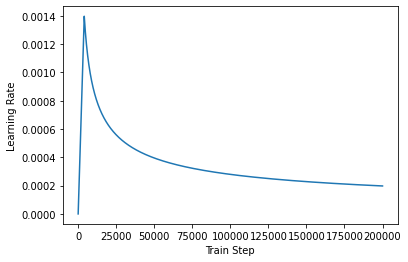

In [30]:
sample_learning_rate = CustomSchedule(d_model=128)

plt.plot(sample_learning_rate(tf.range(200000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### 4. 모델 컴파일

---

손실 함수와 커스텀 된 학습률(learning rate)을 사용하여 모델을 컴파일합니다.

In [31]:
learning_rate = CustomSchedule(D_MODEL)

optimizer = tf.keras.optimizers.Adam(
    learning_rate, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

def accuracy(y_true, y_pred):
  y_true = tf.reshape(y_true, shape=(-1, MAX_LENGTH - 1))
  return tf.keras.metrics.sparse_categorical_accuracy(y_true, y_pred)

model.compile(optimizer=optimizer, loss=loss_function, metrics=[accuracy])
print("힣")

힣


#### 5. 훈련하기
---
이제 학습을 진행해 봅시다.

In [32]:
EPOCHS = 20
model.fit(dataset, epochs=EPOCHS, verbose=1)

Epoch 1/20
185/185 [==============================] - 21s 74ms/step - loss: 1.0460 - accuracy: 0.0171
Epoch 2/20
185/185 [==============================] - 14s 74ms/step - loss: 0.8508 - accuracy: 0.0354
Epoch 3/20
185/185 [==============================] - 14s 74ms/step - loss: 0.7244 - accuracy: 0.0365
Epoch 4/20
185/185 [==============================] - 14s 73ms/step - loss: 0.6689 - accuracy: 0.0391
Epoch 5/20
185/185 [==============================] - 14s 73ms/step - loss: 0.6271 - accuracy: 0.0416
Epoch 6/20
185/185 [==============================] - 14s 74ms/step - loss: 0.5838 - accuracy: 0.0447
Epoch 7/20
185/185 [==============================] - 14s 74ms/step - loss: 0.5358 - accuracy: 0.0491
Epoch 8/20
185/185 [==============================] - 14s 73ms/step - loss: 0.4832 - accuracy: 0.0549
Epoch 9/20
185/185 [==============================] - 14s 73ms/step - loss: 0.4269 - accuracy: 0.0608
Epoch 10/20
185/185 [==============================] - 14s 73ms/step - loss: 0.367

### Step 5. 모델 평가하기

---
Step 1에서 선택한 전처리 방법을 고려하여 입력된 문장에 대해서 대답을 얻는 예측 함수를 만듭니다.

**챗봇 테스트하기**

예측(inference) 단계는 기본적으로 다음과 같은 과정을 거칩니다.

1. 새로운 입력 문장에 대해서는 훈련 때와 동일한 전처리를 거친다.
2. 입력 문장을 토크나이징하고, `START_TOKEN`과 `END_TOKEN`을 추가한다.
3. 패딩 마스킹과 룩 어헤드 마스킹을 계산한다.
4. 디코더는 입력 시퀀스로부터 다음 단어를 예측한다.
5. 디코더는 예측된 다음 단어를 기존의 입력 시퀀스에 추가하여 새로운 입력으로 사용한다.
6. `END_TOKEN`이 예측되거나 문장의 최대 길이에 도달하면 디코더는 동작을 멈춘다.

위의 과정을 모두 담은 `decoder_inference()` 함수를 만듭니다.

In [33]:
def decoder_inference(sentence):
  sentence = preprocess_sentence(sentence)

  # 입력된 문장을 정수 인코딩 후, 시작 토큰과 종료 토큰을 앞뒤로 추가.
  # ex) Where have you been? → [[8331   86   30    5 1059    7 8332]]
  sentence = tf.expand_dims(
      START_TOKEN + tokenizer.encode(sentence) + END_TOKEN, axis=0)

  # 디코더의 현재까지의 예측한 출력 시퀀스가 지속적으로 저장되는 변수.
  # 처음에는 예측한 내용이 없음으로 시작 토큰만 별도 저장. ex) 8331
  output_sequence = tf.expand_dims(START_TOKEN, 0)

  # 디코더의 인퍼런스 단계
  for i in range(MAX_LENGTH):
    # 디코더는 최대 MAX_LENGTH의 길이만큼 다음 단어 예측을 반복합니다.
    predictions = model(inputs=[sentence, output_sequence], training=False)
    predictions = predictions[:, -1:, :]

    # 현재 예측한 단어의 정수
    predicted_id = tf.cast(tf.argmax(predictions, axis=-1), tf.int32)

    # 만약 현재 예측한 단어가 종료 토큰이라면 for문을 종료
    if tf.equal(predicted_id, END_TOKEN[0]):
      break

    # 예측한 단어들은 지속적으로 output_sequence에 추가됩니다.
    # 이 output_sequence는 다시 디코더의 입력이 됩니다.
    output_sequence = tf.concat([output_sequence, predicted_id], axis=-1)

  return tf.squeeze(output_sequence, axis=0)
print("힣")

힣


In [34]:
def sentence_generation(sentence):
  # 입력 문장에 대해서 디코더를 동작 시켜 예측된 정수 시퀀스를 리턴받습니다.
  prediction = decoder_inference(sentence)

  # 정수 시퀀스를 다시 텍스트 시퀀스로 변환합니다.
  predicted_sentence = tokenizer.decode(
      [i for i in prediction if i < tokenizer.vocab_size])

  print('입력 : {}'.format(sentence))
  print('출력 : {}'.format(predicted_sentence))

  return predicted_sentence
print("힣")

힣


In [38]:
sentence_generation('오늘은 뭐해?')

입력 : 오늘은 뭐해?
출력 : 취업이랑 연애 둘 다 잘할 수 있을 거예요 .


'취업이랑 연애 둘 다 잘할 수 있을 거예요 .'

In [36]:
sentence_generation("좋아해")

입력 : 좋아해
출력 : 고백하세요 .


'고백하세요 .'

In [37]:
sentence_generation("널 사랑해")

입력 : 널 사랑해
출력 : 직접 물어보세요 .


'직접 물어보세요 .'

In [39]:
sentence_generation("오늘 날씨 어때?")

입력 : 오늘 날씨 어때?
출력 : 날씨 어플에 물어보세요 .


'날씨 어플에 물어보세요 .'

### 회고

---

ㅠ 나는 챗봇에게 고백하고 차였다.ㅋㅋㅋㅋㅋㅋㅋㅋㅋ

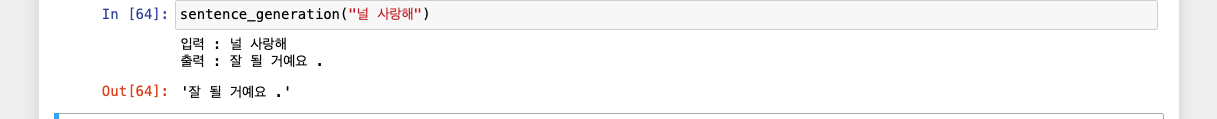

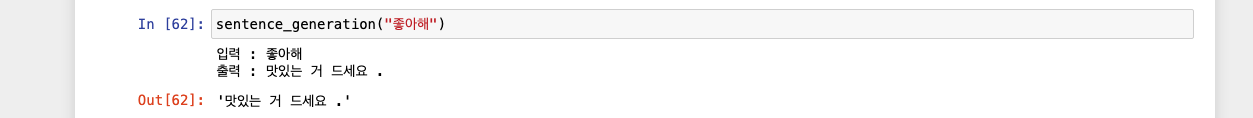

에폭 10 을 돌렸을때 같은 물음에 대한 답이 달랐다. 에폭을 20으로 올렸을때가 확실히 대답이 말이 되었던 것 같다. 